In [6]:
import wfdb
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.signal import resample
import numpy as np
import os 
import json
import pywt
from sklearn.model_selection import train_test_split
import json

# Load paths from JSON file
with open("paths.json", "r") as f:
    paths = json.load(f)

def bandpass_filter(signal, lowcut, highcut, fs, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band', analog=False)
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal

def resample_signal(signal, original_rate , target_rate=360):
    num_samples = int(len(signal) * target_rate / original_rate)
    return resample(signal, num_samples)

folder_path = paths["mit-bih-supra-ventricular"]

dat_files = [os.path.splitext(f)[0] for f in os.listdir(folder_path) if f.endswith('.dat')]

dat_files_train = ['873']
dat_files_test = ['800','803','806','811','875']

remaining = result = [item for item in dat_files if item not in dat_files_train]
remaining = result = [item for item in remaining if item not in dat_files_test]
remaining_train, remaining_test = train_test_split(remaining, test_size=0.47, random_state=42)
dat_files_train+=remaining_train
dat_files_test+=remaining_test

total_data1_train = []
total_data2_train = []

total_data1_test = []
total_data2_test = []


for record_number in dat_files:
    print(record_number)

    # Load ECG data from files
    record = wfdb.rdrecord(f'{folder_path}/{record_number}')
    annotation = wfdb.rdann(f'{folder_path}/{record_number}', 'atr')


    # Extract the signal and plot it
    lead1 = record.p_signal[:, 0]
    lead2 = record.p_signal[:, 1]
    total_samples = len(lead1)
    fs = record.fs


    # Apply a band-pass filter (e.g., 0.5 Hz to 45 Hz)
    lowcut = 0.5 
    highcut = 45
    filtered_lead1 = bandpass_filter(lead1, lowcut, highcut, fs)
    filtered_lead2 = bandpass_filter(lead2, lowcut, highcut, fs)

    annotation_symbols = annotation.symbol
    annotation_sample_numbers = annotation.sample
    data1 = []
    data2 = []
    valid_symbols = ['N','V','F','S']

    rr_intervals = []
    data1 = []
    data2 = []
    five_min_interval_ending= []
    five_min_interval_ending_data = []
    beat_rr_interval_index = []
    current_interval = 1

    for i, symbol in enumerate(annotation_symbols):
        
        
        if(annotation_sample_numbers[i]> ((fs*300)*current_interval + annotation_sample_numbers[0]) and current_interval <= int(((annotation_sample_numbers[-1]-annotation_sample_numbers[0])/(fs*300)))):
            five_min_interval_ending.append(len(rr_intervals))
            five_min_interval_ending_data.append(len(data1))
            current_interval +=1

        #calculate rr inteval
        if(i>1):
            if(symbol in ['+','~','|']):
                continue

            if(annotation_symbols[i-1] not in ['+','~','|']):
                rr_intervals.append(annotation_sample_numbers[i]-annotation_sample_numbers[i-1])
            else:
                rr_intervals.append(annotation_sample_numbers[i]-annotation_sample_numbers[i-2])


            #adding post rr-interval for last valid beat
            if(len(data1)>0 and data1[-1].get('post-rr') is None):
                data1[-1]['post-rr'] = int(rr_intervals[-1])
                data2[-1]['post-rr'] = int(rr_intervals[-1])

        #beat - 61 pre r-peak and 102 post r-peak
        if(symbol in valid_symbols and round(100*fs/360)<=annotation_sample_numbers[i]<=total_samples-round(200*fs/360)):

            #skipping first beat because no pre rr-interval
            if(len(rr_intervals)==0):
                continue

            data_point1 = {}
            data_point1['beat'] = resample_signal(filtered_lead1[annotation_sample_numbers[i]-round(100*fs/360):annotation_sample_numbers[i]+round(200*fs/360)],fs).tolist()
            data_point1['annotation'] = symbol
            data_point1['pre-rr'] = int(rr_intervals[-1])
            data1.append(data_point1)
            

            data_point2 = {}
            data_point2['beat'] = resample_signal(filtered_lead2[annotation_sample_numbers[i]-round(100*fs/360):annotation_sample_numbers[i]+round(200*fs/360)],fs).tolist()
            data_point2['annotation'] = symbol
            data_point2['pre-rr'] = int(rr_intervals[-1])
            data2.append(data_point2)

            beat_rr_interval_index.append(len(rr_intervals)-1)

    #skipping last beat because no post rr-interval
    data1 = data1[:-1]
    data2 = data2[:-1]

    #calculating average rr-intervals
    avearge_rr_intervals = [np.average(np.array(rr_intervals[:five_min_interval_ending[0]]))]

    for i in range(1,len(five_min_interval_ending)):
        avearge_rr_intervals.append(np.average(np.array(rr_intervals[five_min_interval_ending[i-1]:five_min_interval_ending[i]])))


    avearge_rr_intervals.append(np.average(np.array(rr_intervals[five_min_interval_ending[-1]:])))
    
    for i in range(6):
        if(i==0):
            for j in range(0,five_min_interval_ending_data[0]):
                data1[j]['avg-rr'] = avearge_rr_intervals[0]
                data2[j]['avg-rr'] = avearge_rr_intervals[0]
        elif(i==5):
            for j in range(five_min_interval_ending_data[4],len(data1)):
                data1[j]['avg-rr'] = avearge_rr_intervals[5]
                data2[j]['avg-rr'] = avearge_rr_intervals[5]
        else:
            for j in range(five_min_interval_ending_data[i-1],five_min_interval_ending_data[i]):
                data1[j]['avg-rr'] = avearge_rr_intervals[i]
                data2[j]['avg-rr'] = avearge_rr_intervals[i]

    #calculating local rr-intervals
    for i in range(len(data1)):
        data1[i]['local-rr'] = np.average(np.array(rr_intervals[max(0,beat_rr_interval_index[i]-4):min(beat_rr_interval_index[i]+6,len(rr_intervals))]))
        data2[i]['local-rr'] = np.average(np.array(rr_intervals[max(0,beat_rr_interval_index[i]-4):min(beat_rr_interval_index[i]+6,len(rr_intervals))]))

    if(record_number in dat_files_train):
        total_data1_train+=data1
        total_data2_train+=data2
    else:
        total_data1_test+=data1
        total_data2_test+=data2

count_train = {}
count_test = {}

for sym in valid_symbols:
    count_train[sym] = 0
    count_test[sym] = 0

for data in total_data1_train:
    count_train[data['annotation']]+=1

for data in total_data1_test:
    count_test[data['annotation']]+=1

print(count_train)
print(count_test)

803
840
856
848
867
807
874
882
806
842
891
879
892
863
826
843
823
851
869
844
805
850
846
861
865
857
866
804
811
821
860
822
824
801
862
873
885
854
849
855
890
893
894
875
889
880
810
802
853
812
847
887
876
868
883
858
845
870
825
871
884
888
877
820
828
859
852
827
864
829
800
872
878
809
808
881
841
886
{'N': 85955, 'V': 5452, 'F': 17, 'S': 5635}
{'N': 76118, 'V': 4477, 'F': 6, 'S': 6546}


In [7]:

for i in range(len(total_data1_train)):
    beat = np.array(total_data1_train[i]['beat'])

    coeffs = pywt.wavedec(beat, 'db8', level=4)
    A4 = coeffs[0]  
    D4 = coeffs[1]  
    D3 = coeffs[2] 
    wavelet_features = np.concatenate([A4, D4, D3])
    total_data1_train[i]['wave-features'] = wavelet_features

for i in range(len(total_data2_train)):
    beat = np.array(total_data2_train[i]['beat'])

    coeffs = pywt.wavedec(beat, 'db8', level=4)
    A4 = coeffs[0]  
    D4 = coeffs[1]  
    D3 = coeffs[2] 
    wavelet_features = np.concatenate([A4, D4, D3])
    total_data2_train[i]['wave-features'] = wavelet_features

for i in range(len(total_data1_test)):
    beat = np.array(total_data1_test[i]['beat'])

    coeffs = pywt.wavedec(beat, 'db8', level=4)
    A4 = coeffs[0]  
    D4 = coeffs[1]  
    D3 = coeffs[2] 
    wavelet_features = np.concatenate([A4, D4, D3])
    total_data1_test[i]['wave-features'] = wavelet_features

for i in range(len(total_data2_test)):
    beat = np.array(total_data2_test[i]['beat'])

    coeffs = pywt.wavedec(beat, 'db8', level=4)
    A4 = coeffs[0]  
    D4 = coeffs[1]  
    D3 = coeffs[2] 
    wavelet_features = np.concatenate([A4, D4, D3])
    total_data2_test[i]['wave-features'] = wavelet_features

print(len(total_data1_train[0]['wave-features']))
print(len(total_data1_test[0]['wave-features']))

114
114


In [8]:
from sklearn.decomposition import FastICA
import random

random.seed(128)

normal_beats1 = [entry['beat'] for entry in total_data1_train if entry['annotation']=='N']
normal_beats2 = [entry['beat'] for entry in total_data2_train if entry['annotation']=='N']

normal_beats1 = random.sample(normal_beats1, 9753)
normal_beats2 = random.sample(normal_beats2, 9753)

ica1 = FastICA(n_components= 18, random_state=0)
ica1.fit(normal_beats1)

ica2 = FastICA(n_components= 18, random_state=0)
ica2.fit(normal_beats2)

all_beats1_train = [entry['beat'] for entry in total_data1_train]
all_beats2_train = [entry['beat'] for entry in total_data2_train]

all_beats1_test = [entry['beat'] for entry in total_data1_test]
all_beats2_test = [entry['beat'] for entry in total_data2_test]

ica_coef1_train = ica1.transform(all_beats1_train)
ica_coef2_train = ica1.transform(all_beats2_train)

ica_coef1_test = ica1.transform(all_beats1_test)
ica_coef2_test = ica1.transform(all_beats2_test)

for i in range(len(total_data1_train)):
    total_data1_train[i]['ica-features'] = ica_coef1_train[i]

for i in range(len(total_data2_train)):
    total_data2_train[i]['ica-features'] = ica_coef2_train[i]

for i in range(len(total_data1_test)):
    total_data1_test[i]['ica-features'] = ica_coef1_test[i]

for i in range(len(total_data2_test)):
    total_data2_test[i]['ica-features'] = ica_coef2_test[i]


In [9]:
from sklearn.decomposition import PCA

features1_train = [np.concatenate((entry['wave-features'],entry['ica-features'])) for entry in total_data1_train]
features2_train = [np.concatenate((entry['wave-features'],entry['ica-features'])) for entry in total_data2_train]

features1_test = [np.concatenate((entry['wave-features'],entry['ica-features'])) for entry in total_data1_test]
features2_test = [np.concatenate((entry['wave-features'],entry['ica-features'])) for entry in total_data2_test]

pca1_train = PCA(n_components=26)
pca2_train = PCA(n_components=26)

pca1_test = PCA(n_components=26)
pca2_test = PCA(n_components=26)

reduced_features1_train = pca1_train.fit_transform(features1_train)
reduced_features2_train = pca1_train.fit_transform(features2_train)

reduced_features1_test = pca1_test.fit_transform(features1_test)
reduced_features2_test = pca1_test.fit_transform(features2_test)

final_data1_train = []

for i, entry in enumerate(total_data1_train):
    data = {}
    data['features'] = np.concatenate((reduced_features1_train[i] ,[entry['pre-rr'],entry['post-rr'],entry['local-rr'],entry['avg-rr']])).tolist()
    data['label'] = entry['annotation']
    final_data1_train.append(data)

final_data2_train = []

for i, entry in enumerate(total_data2_train):
    data = {}
    data['features'] = np.concatenate((reduced_features2_train[i], [entry['pre-rr'],entry['post-rr'],entry['local-rr'],entry['avg-rr']])).tolist()
    data['label'] = entry['annotation']
    final_data2_train.append(data)

final_data1_test = []

for i, entry in enumerate(total_data1_test):
    data = {}
    data['features'] = np.concatenate((reduced_features1_test[i] ,[entry['pre-rr'],entry['post-rr'],entry['local-rr'],entry['avg-rr']])).tolist()
    data['label'] = entry['annotation']
    final_data1_test.append(data)

final_data2_test = []

for i, entry in enumerate(total_data2_test):
    data = {}
    data['features'] = np.concatenate((reduced_features2_test[i], [entry['pre-rr'],entry['post-rr'],entry['local-rr'],entry['avg-rr']])).tolist()
    data['label'] = entry['annotation']
    final_data2_test.append(data)


In [10]:
data_by_label_train = {}

for i in range(len(final_data1_train)):
    label = final_data1_train[i]['label']
    features1 = final_data1_train[i]['features']
    features2 = final_data2_train[i]['features']
    if label not in data_by_label_train:
        data_by_label_train[label] = []
    data_by_label_train[label].append({'features1':features1, 'features2':features2, 'label':label})


test = []
for i in range(len(final_data1_test)):
    label = final_data1_test[i]['label']
    features1 = final_data1_test[i]['features']
    features2 = final_data2_test[i]['features']
    test.append({'features1':features1, 'features2':features2, 'label':label})

print(data_by_label_train.keys())

dict_keys(['N', 'V', 'S', 'F'])


In [11]:
import random
from sklearn.model_selection import train_test_split

train_size = {'N': 0.12, 'V': 0.8, 'F': 1, 'S': 0.8}
train = []
for label, features in data_by_label_train.items():
    if(train_size[label]==1.0):
        train.extend(features)
    else:
        f_train, f_test = train_test_split(features, train_size = train_size[label], random_state=42)
        train.extend(f_train)

random.seed(42)
random.shuffle(train)
random.shuffle(test)

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

train_1  = [elem['features1'] for elem in train]
train_2 = [elem['features2'] for elem in train]
train_label = [elem['label'] for elem in train]

test_1  = [elem['features1'] for elem in test]
test_2 = [elem['features2'] for elem in test]
test_label = [elem['label'] for elem in test]

n = len(train_1)
scalar = StandardScaler()
train_1.extend(test_1)
scaled_1  = scalar.fit_transform(train_1)
train_1 = scaled_1[:n]
test_1 = scaled_1[n:]
train_2.extend(test_2)
scaled_2  = scalar.fit_transform(train_2)
train_2 = scaled_2[:n]
test_2 = scaled_2[n:]

model1 = SVC(kernel='rbf',random_state=42, C = 100, gamma=0.01)

model1.fit(train_1,train_label)

label_train_pred1 = model1.predict(train_1)
train_accuracy1= accuracy_score(train_label, label_train_pred1)
print(f"Training Accuracy lead 1 : {train_accuracy1:.4f}")

label_test_pred1 = model1.predict(test_1)
test_accuracy1 = accuracy_score(test_label, label_test_pred1)
print(f"Testing Accuracy lead 1: {test_accuracy1:.4f}")


joblib.dump(model1, 'model_1.pkl')


Training Accuracy lead 1 : 0.9788
Testing Accuracy lead 1: 0.7757


['model_1.pkl']

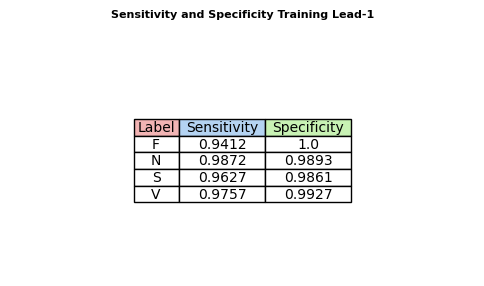

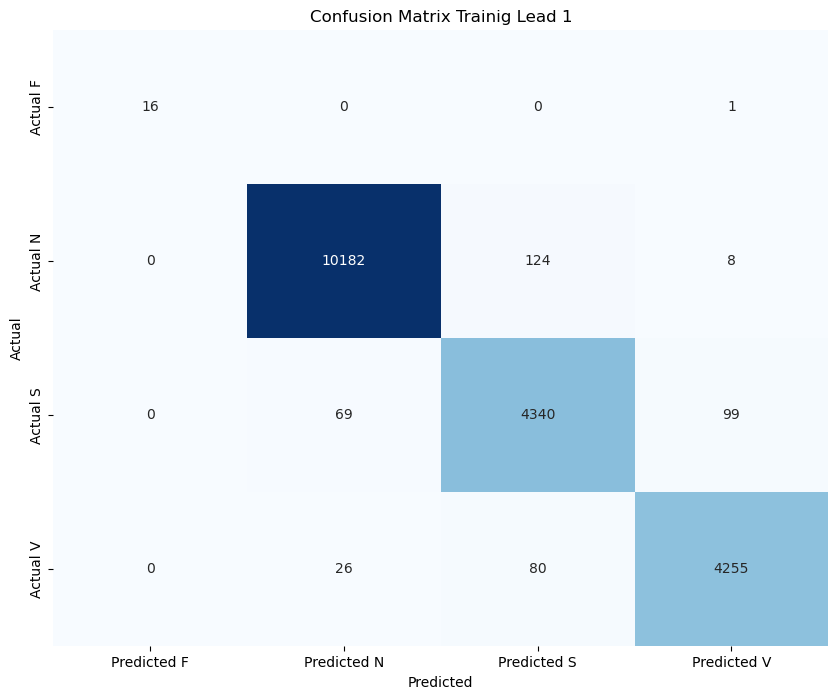

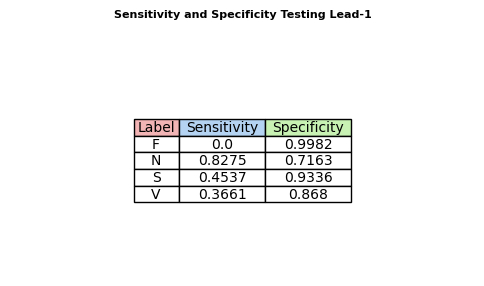

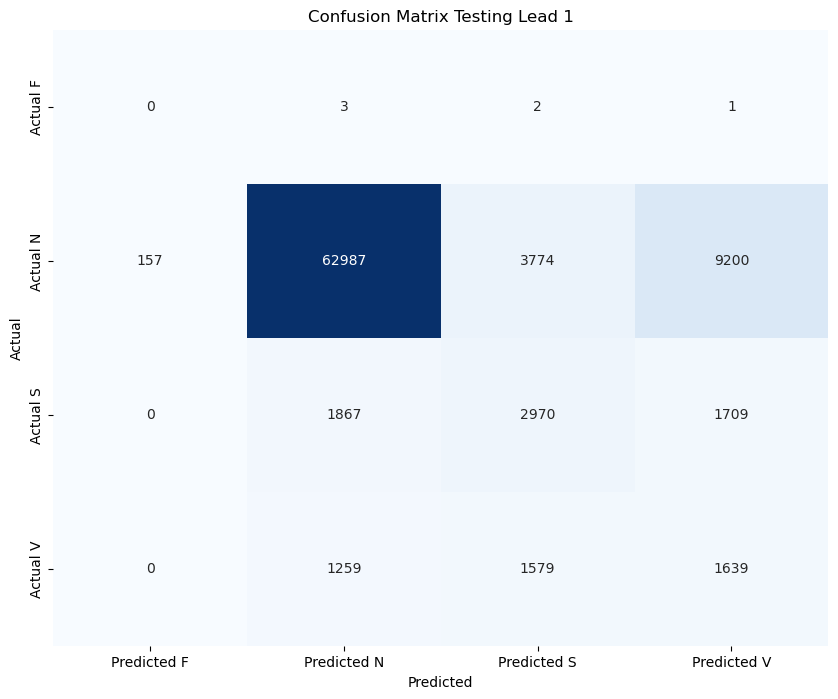

In [13]:
def calc_sen_spe(conf_matrix, classes):
    conf_matrix = np.array(conf_matrix)
    sensitivity = {}
    specificity = {}
    for i in range(len(conf_matrix)):
        TP = conf_matrix[i, i]
        FN = np.sum(conf_matrix[i, :]) - TP
        FP = np.sum(conf_matrix[:, i]) - TP
        TN = np.sum(conf_matrix) - (TP + FN + FP)
        
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0
        
        sensitivity [classes[i]]=sens
        specificity[classes[i]]=spec
    return sensitivity, specificity

conf_matrix_train1 = confusion_matrix(train_label, label_train_pred1, labels=model1.classes_)

sens_train1, spec_train1 = calc_sen_spe(conf_matrix_train1,model1.classes_)
table_train1 = {
    "Label": list(sens_train1.keys()),
    "Sensitivity": [round(val, 4) for val in sens_train1.values()],
    "Specificity": [round(val, 4) for val in spec_train1.values()],
}
table_train1 = pd.DataFrame(table_train1)

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed
ax.axis('off')  # Turn off the axes
table = ax.table(
    cellText=table_train1.values,
    colLabels=table_train1.columns,
    cellLoc='center',
    loc='center',
    colColours=["#f2b4b4", "#b4d3f2", "#c8f2b4"],  
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_train1.columns))))  # Adjust column width

ax.set_title(
    "Sensitivity and Specificity Training Lead-1",
    fontsize=8,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()

conf_matrix_df_train1 = pd.DataFrame(
    conf_matrix_train1, 
    index=[f"Actual {label}" for label in model1.classes_], 
    columns=[f"Predicted {label}" for label in model1.classes_]
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df_train1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Trainig Lead 1")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

conf_matrix_test1 = confusion_matrix(test_label, label_test_pred1, labels=model1.classes_)

sens_test1, spec_test1 = calc_sen_spe(conf_matrix_test1,model1.classes_)
table_test1 = {
    "Label": list(sens_test1.keys()),
    "Sensitivity": [round(val, 4) for val in sens_test1.values()],
    "Specificity": [round(val, 4) for val in spec_test1.values()],
}
table_test1 = pd.DataFrame(table_test1)

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed
ax.axis('off')  # Turn off the axes
table = ax.table(
    cellText=table_test1.values,
    colLabels=table_test1.columns,
    cellLoc='center',
    loc='center',
    colColours=["#f2b4b4", "#b4d3f2", "#c8f2b4"],  
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_test1.columns))))  # Adjust column width

ax.set_title(
    "Sensitivity and Specificity Testing Lead-1",
    fontsize=8,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()

conf_matrix_df_test1 = pd.DataFrame(
    conf_matrix_test1, 
    index=[f"Actual {label}" for label in model1.classes_], 
    columns=[f"Predicted {label}" for label in model1.classes_]
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df_test1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Testing Lead 1")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()



In [14]:
model2 = SVC(kernel='rbf',random_state=42, C = 100, gamma=0.01)

model2.fit(train_2,train_label)

label_train_pred2 = model2.predict(train_2)
train_accuracy2 = accuracy_score(train_label, label_train_pred2)
print(f"Training Accuracy for lead 2: {train_accuracy2:.4f}")

label_test_pred2 = model2.predict(test_2)
test_accuracy2 = accuracy_score(test_label, label_test_pred2)
print(f"Testing Accuracy for lead 2: {test_accuracy2:.4f}")

joblib.dump(model2, 'model_2.pkl')

Training Accuracy for lead 2: 0.9788
Testing Accuracy for lead 2: 0.8183


['model_2.pkl']

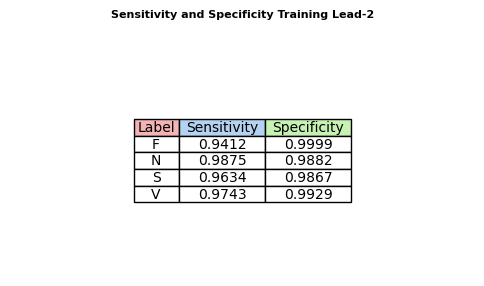

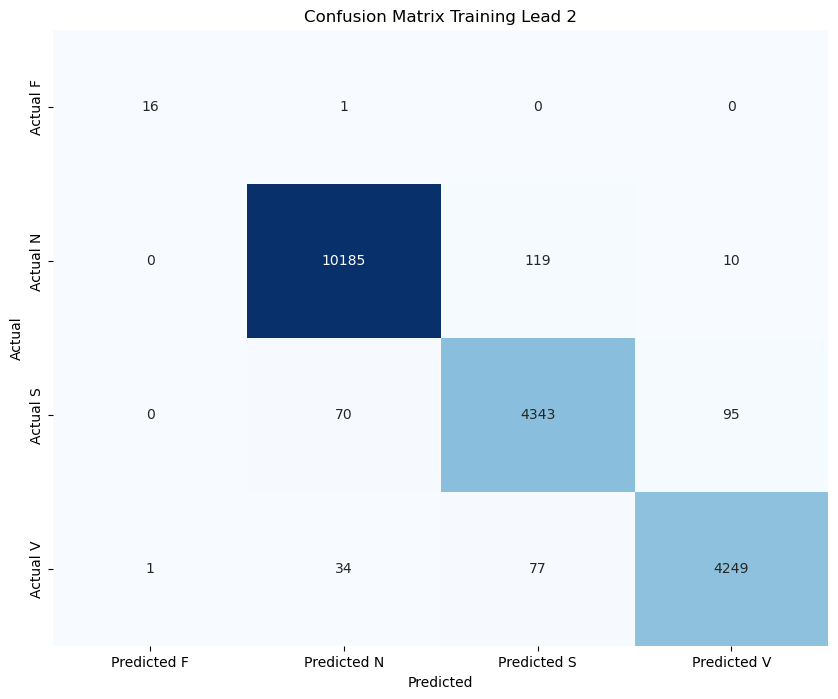

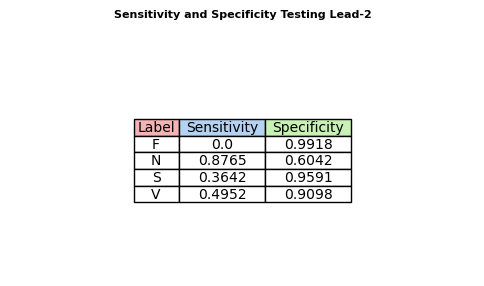

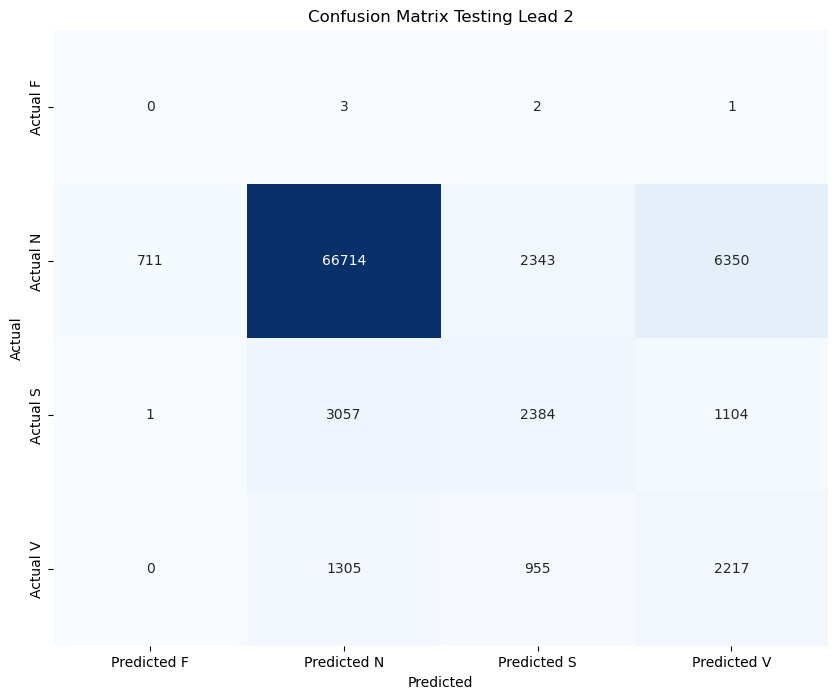

In [15]:
conf_matrix_train2 = confusion_matrix(train_label, label_train_pred2, labels=model2.classes_)

sens_train2, spec_train2 = calc_sen_spe(conf_matrix_train2,model2.classes_)
table_train2 = {
    "Label": list(sens_train2.keys()),
    "Sensitivity": [round(val, 4) for val in sens_train2.values()],
    "Specificity": [round(val, 4) for val in spec_train2.values()],
}
table_train2 = pd.DataFrame(table_train2)

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed
ax.axis('off')  # Turn off the axes
table = ax.table(
    cellText=table_train2.values,
    colLabels=table_train2.columns,
    cellLoc='center',
    loc='center',
    colColours=["#f2b4b4", "#b4d3f2", "#c8f2b4"],  
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_train2.columns))))  # Adjust column width

ax.set_title(
    "Sensitivity and Specificity Training Lead-2",
    fontsize=8,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()

conf_matrix_df_train2 = pd.DataFrame(
    conf_matrix_train2, 
    index=[f"Actual {label}" for label in model2.classes_], 
    columns=[f"Predicted {label}" for label in model2.classes_]
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df_train2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Training Lead 2")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

conf_matrix_test2 = confusion_matrix(test_label, label_test_pred2, labels=model2.classes_)

sens_test2, spec_test2 = calc_sen_spe(conf_matrix_test2,model2.classes_)
table_test2 = {
    "Label": list(sens_test2.keys()),
    "Sensitivity": [round(val, 4) for val in sens_test2.values()],
    "Specificity": [round(val, 4) for val in spec_test2.values()],
}
table_test2 = pd.DataFrame(table_test2)

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed
ax.axis('off')  # Turn off the axes
table = ax.table(
    cellText=table_test2.values,
    colLabels=table_test2.columns,
    cellLoc='center',
    loc='center',
    colColours=["#f2b4b4", "#b4d3f2", "#c8f2b4"],  
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_test2.columns))))  # Adjust column width

ax.set_title(
    "Sensitivity and Specificity Testing Lead-2",
    fontsize=8,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()

conf_matrix_df_test2 = pd.DataFrame(
    conf_matrix_test2, 
    index=[f"Actual {label}" for label in model2.classes_], 
    columns=[f"Predicted {label}" for label in model2.classes_]
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df_test2, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Testing Lead 2")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

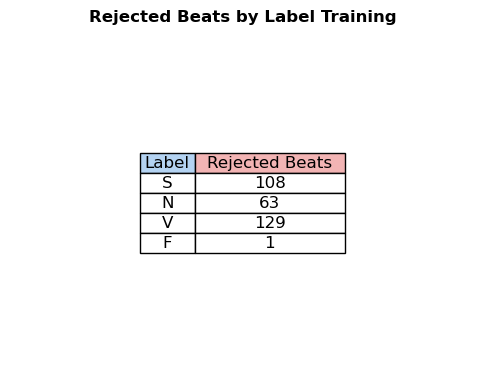

Training Accuracy combined: 0.9866130483094344 with rejected 301 beats


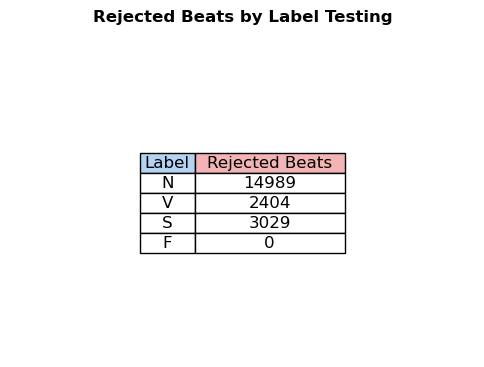

Testing Accuracy combined: 0.9139452978643686 with rejected 20422 beats


In [16]:
def accuracy_combined(label_pred1, label_pred2, actual_label):
    label_pred_both = []
    rejected = {}
    for i in range(len(label_pred1)):
        if(label_pred1[i]==label_pred2[i]):
            label_pred_both.append(label_pred1[i])
        else:
            label_pred_both.append('NA')
            if(actual_label[i] not in rejected):
                rejected[actual_label[i]] = 0
            rejected[actual_label[i]]+=1
            
    for cls in model1.classes_ :
        if cls not in rejected:
            rejected[cls]=0
    
    correct = 0
    total =  0
    unrejected_label_pred = []
    unrejected_label_true = []
    for i in range(len(label_pred1)):
        if(label_pred_both[i]=='NA'):
            continue
        if(label_pred_both[i]==actual_label[i]):
            correct+=1
        unrejected_label_pred.append(label_pred_both[i])
        unrejected_label_true.append(actual_label[i])
        total+=1
    
    return correct/total, unrejected_label_true, unrejected_label_pred , rejected

accuracy_combined_train, unrejected_label_train, unrejected_label_train_pred, rejected_label_train = accuracy_combined(label_train_pred1, label_train_pred2,train_label)
accuracy_combined_test, unrejected_label_test, unrejected_label_test_pred, rejected_label_test = accuracy_combined(label_test_pred1, label_test_pred2,test_label)

rejected_table_train = {
    "Label": list(rejected_label_train.keys()),
    "Rejected Beats": list(rejected_label_train.values()),
}
rejected_table_train = pd.DataFrame(rejected_table_train)

# Plot the table
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust size as needed
ax.axis('off')  # Turn off the axes

# Add table to plot
table = ax.table(
    cellText=rejected_table_train.values,
    colLabels=rejected_table_train.columns,
    cellLoc='center',
    loc='center',
    colColours=["#b4d3f2", "#f2b4b4"],  # Header colors
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(rejected_table_train.columns))))  # Adjust column widths
table.scale(1.2, 1.2)  # Scale table for better readability

# Add title to the table
ax.set_title(
    "Rejected Beats by Label Training",
    fontsize=12,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()


print(f"Training Accuracy combined: {accuracy_combined_train} with rejected {len(train_label) - len(unrejected_label_train)} beats")

rejected_table_test = {
    "Label": list(rejected_label_test.keys()),
    "Rejected Beats": list(rejected_label_test.values()),
}
rejected_table_test = pd.DataFrame(rejected_table_test)

# Plot the table
fig, ax = plt.subplots(figsize=(6, 4))  # Adjust size as needed
ax.axis('off')  # Turn off the axes

# Add table to plot
table = ax.table(
    cellText=rejected_table_test.values,
    colLabels=rejected_table_test.columns,
    cellLoc='center',
    loc='center',
    colColours=["#b4d3f2", "#f2b4b4"],  # Header colors
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(rejected_table_test.columns))))  # Adjust column widths
table.scale(1.2, 1.2)  # Scale table for better readability

# Add title to the table
ax.set_title(
    "Rejected Beats by Label Testing",
    fontsize=12,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()

print(f"Testing Accuracy combined: {accuracy_combined_test} with rejected {len(test_label) - len(unrejected_label_test)} beats")

        

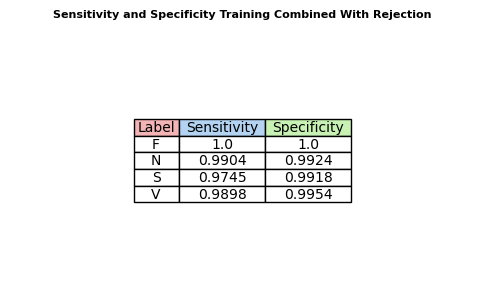

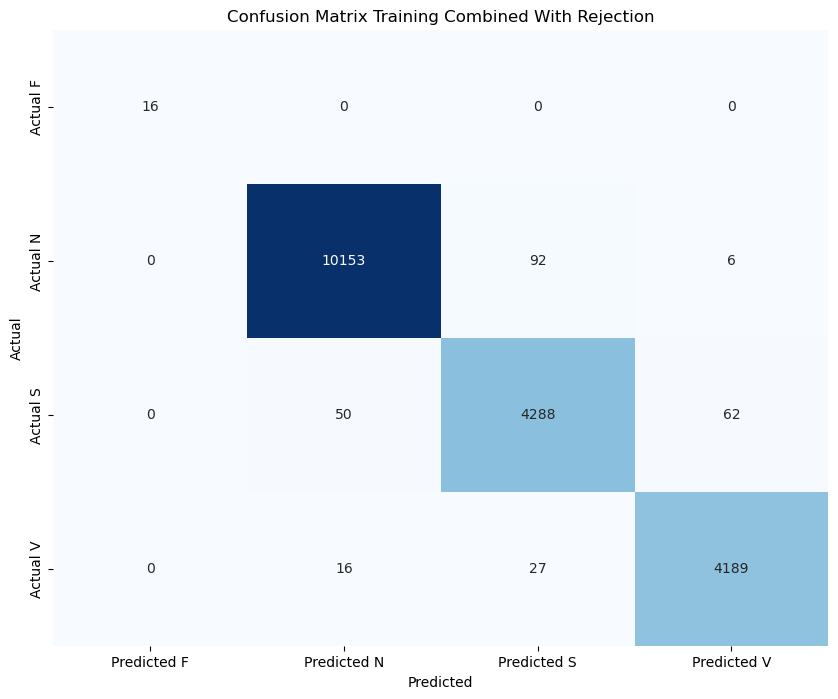

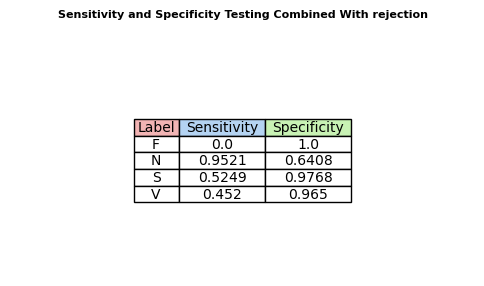

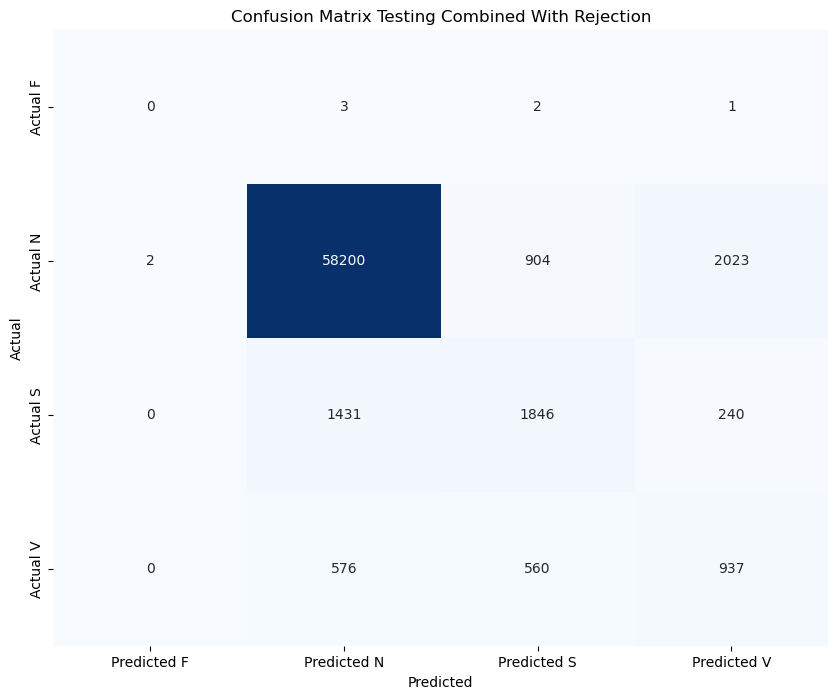

In [17]:
conf_matrix_train_comb = confusion_matrix(unrejected_label_train, unrejected_label_train_pred, labels=model2.classes_)

sens_train_comb, spec_train_comb = calc_sen_spe(conf_matrix_train_comb,model2.classes_)
table_train_comb = {
    "Label": list(sens_train_comb.keys()),
    "Sensitivity": [round(val, 4) for val in sens_train_comb.values()],
    "Specificity": [round(val, 4) for val in spec_train_comb.values()],
}
table_train_comb = pd.DataFrame(table_train_comb)

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed
ax.axis('off')  # Turn off the axes
table = ax.table(
    cellText=table_train_comb.values,
    colLabels=table_train_comb.columns,
    cellLoc='center',
    loc='center',
    colColours=["#f2b4b4", "#b4d3f2", "#c8f2b4"],  
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_train_comb.columns))))  # Adjust column width

ax.set_title(
    "Sensitivity and Specificity Training Combined With Rejection",
    fontsize=8,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()


conf_matrix_df_train_comb = pd.DataFrame(
    conf_matrix_train_comb, 
    index=[f"Actual {label}" for label in model2.classes_], 
    columns=[f"Predicted {label}" for label in model2.classes_]
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df_train_comb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Training Combined With Rejection")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

conf_matrix_test_comb = confusion_matrix(unrejected_label_test, unrejected_label_test_pred, labels=model2.classes_)

sens_test_comb, spec_test_comb = calc_sen_spe(conf_matrix_test_comb,model2.classes_)
table_test_comb = {
    "Label": list(sens_test_comb.keys()),
    "Sensitivity": [round(val, 4) for val in sens_test_comb.values()],
    "Specificity": [round(val, 4) for val in spec_test_comb.values()],
}
table_test_comb = pd.DataFrame(table_test_comb)

fig, ax = plt.subplots(figsize=(6, 3))  # Adjust size as needed
ax.axis('off')  # Turn off the axes
table = ax.table(
    cellText=table_test_comb.values,
    colLabels=table_test_comb.columns,
    cellLoc='center',
    loc='center',
    colColours=["#f2b4b4", "#b4d3f2", "#c8f2b4"],  
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(table_test_comb.columns))))  # Adjust column width

ax.set_title(
    "Sensitivity and Specificity Testing Combined With rejection",
    fontsize=8,
    weight='bold',
    pad=20,  # Padding between title and table
)

# Show the table
plt.show()
conf_matrix_df_test_comb = pd.DataFrame(
    conf_matrix_test_comb, 
    index=[f"Actual {label}" for label in model2.classes_], 
    columns=[f"Predicted {label}" for label in model2.classes_]
)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df_test_comb, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix Testing Combined With Rejection")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()